# Shadow yellow lines detection in HSV space

This notebook is based on Juejie's code and my code on edge detection along with line detection.

In [1]:
# load libraries 
from pathlib import Path
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import os
import cv2

In [2]:
# based on Junjie's code 

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

class Yellow:

    def __init__(self):

        img = cv2.imread("Parking Lot/Lot3.tif")
        img_data = np.array(img)

        self.b = np.mean(img_data[205:215, 600:1000, 0])
        self.g = np.mean(img_data[205:215, 600:1000, 1])
        self.r = np.mean(img_data[205:215, 600:1000, 2])
        self.bgr = np.array([self.b,self.g,self.r])

    def rgb(self):
        return np.array([self.r, self.g, self.b])

    def hsv(self):
        return cv2.cvtColor(np.float32(self.bgr.reshape((1,1,3))),cv2.COLOR_BGR2HSV).reshape(3)


class Yellow_Shadowed:

    def __init__(self):

        img_data = np.array(rotate_image(cv2.imread("Parking Lot/Lot11.tif"), 2))
        dims = img_data.shape

        self.b = np.mean(img_data[1100:1375, 2040:2055, 0])
        self.g = np.mean(img_data[1100:1375, 2040:2055, 1])
        self.r = np.mean(img_data[1100:1375, 2040:2055, 2])
        self.bgr = np.array([self.b,self.g,self.r])

    def rgb(self):
        return np.array([self.r, self.g, self.b])

    def hsv(self):
        return cv2.cvtColor(np.float32(self.bgr.reshape((1,1,3))),cv2.COLOR_BGR2HSV).reshape(3)


In [3]:
WIDTH = 512
HEIGHT = 512

In [4]:
pl = Path("Parking Lot")
rd = Path("Road")

filenames = [str(file) for file in pl.iterdir()]
filenames = filenames + [str(file) for file in rd.iterdir()]

num_files = len(filenames)

In [5]:
# load resized images in RGB and HSV
ims = [cv2.imread(file) for file in filenames]
hsv_ims = [cv2.cvtColor(im, cv2.COLOR_BGR2HSV) for im in ims]

ims = [np.array(cv2.resize(im, (WIDTH,HEIGHT))) for im in ims]
hsv_ims = [np.array(cv2.resize(im, (WIDTH,HEIGHT))) for im in hsv_ims]

hsv_pixel_list = [hsv_im.reshape((-1, 3)) for hsv_im in hsv_ims]
hsv_pixels = np.concatenate(hsv_pixel_list, axis=0)

In [6]:
# color quantization
n_clusters=10

model = KMeans(n_clusters=n_clusters)
model.fit(hsv_pixels)

KMeans(n_clusters=10)

In [7]:
# call the reference colors
y = Yellow()
ys = Yellow_Shadowed()

In [8]:
yellows = np.array([y.hsv(), ys.hsv()]).astype(np.uint8)

In [9]:
yellow_labels = model.predict(yellows)

In [10]:
# save the results 
for index in range(num_files):

    colors = model.cluster_centers_
    img_labels = model.labels_[HEIGHT*WIDTH*index:HEIGHT*WIDTH*(index+1)]
    transformed_img = cv2.cvtColor(np.float32(colors[img_labels].reshape((HEIGHT, WIDTH, 3))), cv2.COLOR_HSV2RGB)

    filename = filenames[index].split('/')[-1].split('.')[0]
    output_name = "Output/Color_Quantization_with_Shadow_HSV/Transformed_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name, transformed_img)

    mask = np.logical_or(img_labels==yellow_labels[0], img_labels==yellow_labels[1]).reshape((HEIGHT, WIDTH, 1))
    masked_image = ims[index]*mask
    output_name = "Output/Color_Quantization_with_Shadow_HSV/Masked_"+filename+".jpg"
    os.makedirs(os.path.dirname(output_name), exist_ok=True)
    cv2.imwrite(output_name, masked_image)


Load the lot image and do edge and line detection.

Our resized image has the shape: (512, 512, 3)


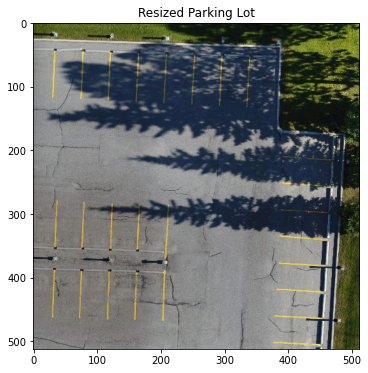

In [11]:
filen = "Lot11"
resizedfilename = "Output/Color_Quantization_2/Resized_"+filen+".jpg"
img_resized = cv2.imread(resizedfilename, 1)
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.title('Resized Parking Lot');
print("Our resized image has the shape: {}".format(img_resized.shape))
plt.imshow(img_resized)
plt.show()

Our masked image has the shape: (512, 512, 3)


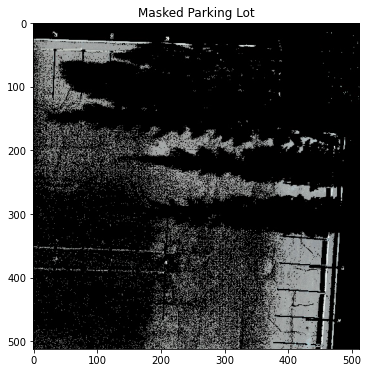

In [12]:
maskedfilename = "Output/Color_Quantization_with_Shadow_HSV/Masked_"+filen+".jpg"
masked_img = cv2.imread(maskedfilename, 1)

plt.figure(figsize=(6,6))
plt.title('Masked Parking Lot');
print("Our masked image has the shape: {}".format(masked_img.shape))
plt.imshow(masked_img)
plt.show()

In [13]:
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)

In [14]:
# parameters kernel size 
gblur = cv2.GaussianBlur(masked_img, (7,7),0)

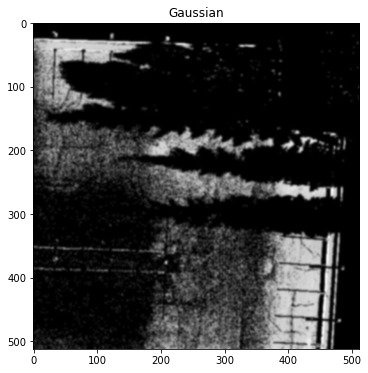

In [15]:
plt.figure(figsize=(6,6))
plt.imshow(gblur, cmap = 'gray')
plt.title('Gaussian');
plt.show()

In [16]:
# two parameters need to play with in Canny edge detection
minval = 150
maxval = 280
canny_bF = cv2.Canny(gblur, minval, maxval)

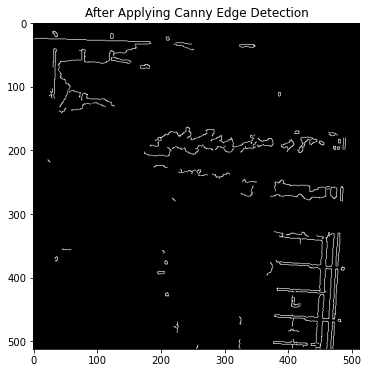

True

In [17]:
plt.figure(figsize=(6,6))
plt.imshow(canny_bF, cmap = 'gray')
plt.title('After Applying Canny Edge Detection');
plt.show()
finaloutname = "Output/Color_Quantization_with_Shadow_HSV/Edge_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
cv2.imwrite(finaloutname,canny_bF )

In [18]:
# three parameters need to play with in Hough line detection
lines = cv2.HoughLinesP(canny_bF, 1, np.pi/180, threshold = 19, minLineLength = 10, maxLineGap = 10)
img_resized = cv2.imread(resizedfilename, 1)

In [19]:
# draw lines
for line in lines:
    x1, y1, x2, y2 = line[0]   
    cv2.line(img_resized, (x1,y1), (x2, y2), ( 0, 0, 255), 2)

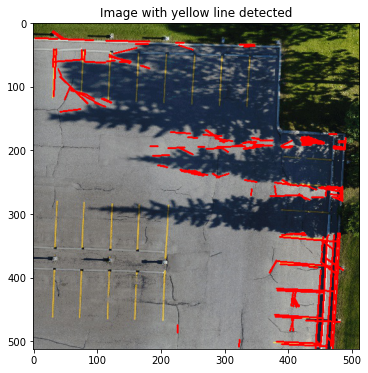

In [20]:
# save the image with line detected and display it
finaloutname = "Output/Color_Quantization_with_Shadow_HSV/Detected_"+filen+".jpg"
os.makedirs(os.path.dirname(finaloutname), exist_ok=True)
cv2.imwrite(finaloutname, img_resized)

img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img_resized)
plt.title('Image with yellow line detected');
plt.show()

It doesn't really work. We should look for better solution for deal with the shadow.